# Use Neural Priors

In [the sampling tutorial](sampling), we have demonstrated how to define parameters with priors.
This guide shows you how to set up and use neural network priors.
We make use of the related package [`galaxygrad`](https://github.com/SampsonML/galaxygrad), which can be pip-installed.

This guide will follow the [Quick Start Guide](../0-quickstart), with changes in the initialization and parameter specification. We assume that you have a full installation of _scarlet2_ including `optax`, `numpyro`, `h5py` and `galaxygrad`.

More details about the use of a score-based prior model for diffusion can be found in the paper ["Score-matching neural networks for improved multi-band source separation", Sampson et al., 2024, A&C, 49, 100875](http://ui.adsabs.harvard.edu/abs/2024A&C....4900875S).

In [1]:
# Import Packages and setup
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os
from scarlet2 import *

## Create Observation

Again we import the test data and create the observation:

In [2]:
# load the data
from scarlet2.utils import import_scarlet_test_data
import_scarlet_test_data()
from scarlet_test_data import data_path

file = jnp.load(os.path.join(data_path, "hsc_cosmos_35.npz"))
data = jnp.asarray(file["images"])
channels = list(file['filters'])
centers = jnp.array([(src['y'], src['x']) for src in file["catalog"]])
weights = jnp.asarray(1/file["variance"])
psf = jnp.asarray(file["psfs"])

# create the observation
model_psf = GaussianPSF(0.7)
model_frame = Frame(Box(data.shape), psf=model_psf, channels=channels)
obs = Observation(data,
                  weights,
                  psf=ArrayPSF(psf),
                  channels=channels,
                  ).match(model_frame)

## Initialize Sources

In [3]:
with Scene(model_frame) as scene:
    for i, center in enumerate(centers):
        if i == 0: # we know source 0 is a star
            spectrum = init.pixel_spectrum(obs, center)
            PointSource(center, spectrum)
        else:
            try:
                spectrum, morph = init.from_gaussian_moments(obs, center, min_corr=0.99)
            except ValueError:
                spectrum = init.pixel_spectrum(obs, center)
                morph = init.compact_morphology()

            Source(center, spectrum, morph)

## Load Neural Prior

In [4]:
# loading neural priors new method 
from galaxygradtemp import show_available_models, get_prior

/Users/mattsampson/miniconda3/envs/scorenet2024/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We can see what models are currently available in the huggingface hosted repository

In [5]:
print(show_available_models())

Available models:
----------------------
<>   hsc32
<>   hsc64
<>   ztf32
<>   ztf64
<>   roman120
<>   lsst60
<>   quasar72
----------------------
see: {https://huggingface.co/sampsonML/galaxy-score-based-diffusion-models/} for more information on the models and their training.
contact https://github.com/sampsonML for any issues or questions (requests to train new priors).
None


We may now choose to load a model from its name, we can specify a location to download this to.

In [6]:
local_dir = "/Users/mattsampson/Downloads/test/"
prior = get_prior('hsc32', local_dir=local_dir)
print(f"model located at {prior.path}")

model located at /Users/mattsampson/Downloads/test/eqx_hsc_ScoreNet32.eqx


Or we can use the huggingface default .cache location by not specifying a path

In [7]:
prior = get_prior('hsc32')
print(f"model located at {prior.path}")

model located at /Users/mattsampson/.cache/huggingface/hub/models--sampsonML--galaxy-score-based-diffusion-models/snapshots/263c422a31da9ba074fe51ed40fc5e162aab2aae/eqx_hsc_ScoreNet32.eqx


This prior is a class which contains information about the model in prior.info(), or we can see specific things like the shape with prior.shape(), or the location of the downloaded model path with prior.path as already seen.

In [8]:
print(f"shape of this prior is {prior.shape()}")

shape of this prior is (32, 32)


In [9]:
# see full information 
print(prior.info())

HSC prior model
-----------------------
This model is trained on Scarlet1 deblends from 
the HSC survey
Model size: 32x32
Model path: /Users/mattsampson/.cache/huggingface/hub/models--sampsonML--galaxy-score-based-diffusion-models/snapshots/263c422a31da9ba074fe51ed40fc5e162aab2aae/eqx_hsc_ScoreNet32.eqx
None


In [10]:
# load in the model you wish to use
from scarlet2.nn import ScorePrior

prior32 = get_prior('hsc32')
prior64 = get_prior('hsc64')

# instantiate the prior class
temp = 1e-2 # values in the range of [1e-3, 1e-1] produce good results
prior32 = ScorePrior(prior32, prior32.shape(), t=temp)
prior64 = ScorePrior(prior64, prior64.shape(), t=temp)

The prior model itself is in the form of a score-based diffusion model, which matches the score function, i.e. the gradient of the log-likelihood of the training data with respect to the parameters. For an image-based parameterization, the free parameters are the pixels, which means the gradient has the same shape as the image. `galaxygrad` provides several pre-trained models, here we use a prior that was trained on deblended isolate source in HSC data, with the shapes of 32x32 or 64x64, respectively. These sizes denote the maximum image size for which the prior is trained.

We import {py:class}`~scarlet2.nn.ScorePrior` to use with our prior. It automatically zero-pads any smaller image array up to the specified size and provides a custom gradient path that calls the underlying score model during optimization or HMC sampling. The `temp` argument refers to a fixed temperature for the diffusion process. For speed, we run a single diffusion step with the given temperature.

## Define Parameters with Prior

We use the same fitting routine as in the Quickstart guide, but replace `contraints.positive` with `prior=prior` in the Parameter containing the source morphologies. It is also useful to reduce the step size for the morphology updates because large jumps can lead to unstable prior gradients.

In [11]:
from functools import partial
from numpyro.distributions import constraints
spec_step = partial(relative_step, factor=0.01)
morph_step = partial(relative_step, factor=1e-3)

parameters = scene.make_parameters()
for i in range(len(scene.sources)):
    parameters += Parameter(scene.sources[i].spectrum.data,
                            name=f"spectrum:{i}",
                            constraint=constraints.positive,
                            stepsize=spec_step)
    if i == 0:
        parameters += Parameter(scene.sources[i].center,
                                name=f"center:{i}",
                                stepsize=0.1)
    else:
        # chose a prior of suitable size
        prior = prior32 if max(scene.sources[i].morphology.data.shape) <= 32 else prior64
        parameters += Parameter(scene.sources[i].morphology.data,
                                name=f"morph:{i}",
                                prior=prior, # attach the prior here
                                stepsize=morph_step)

Note that the use of a `prior` is incompatible with the use of a `constraint`.

We again perform the fitting:

In [12]:
maxiter = 1000
scene.set_spectra_to_match(obs, parameters)
scene_ = scene.fit(obs, parameters, max_iter=maxiter, e_rel=1e-3, progress_bar=False)

The fit converges about half-way through, but reaches values a little bit worse than for morphologies with the positivity constraint in the quickstart guide.

## Check Results

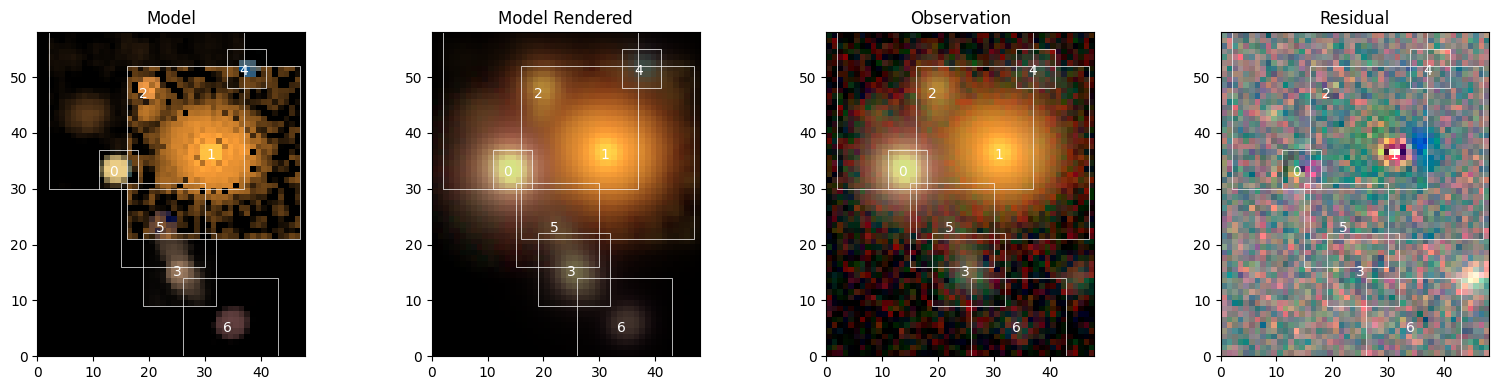

In [13]:
norm = plot.AsinhAutomaticNorm(obs)
plot.scene(scene_,
           obs,
           norm=norm,
           show_model=True,
           show_rendered=True,
           show_observed=True,
           show_residual=True,
           add_boxes=True,
           )
plt.show()

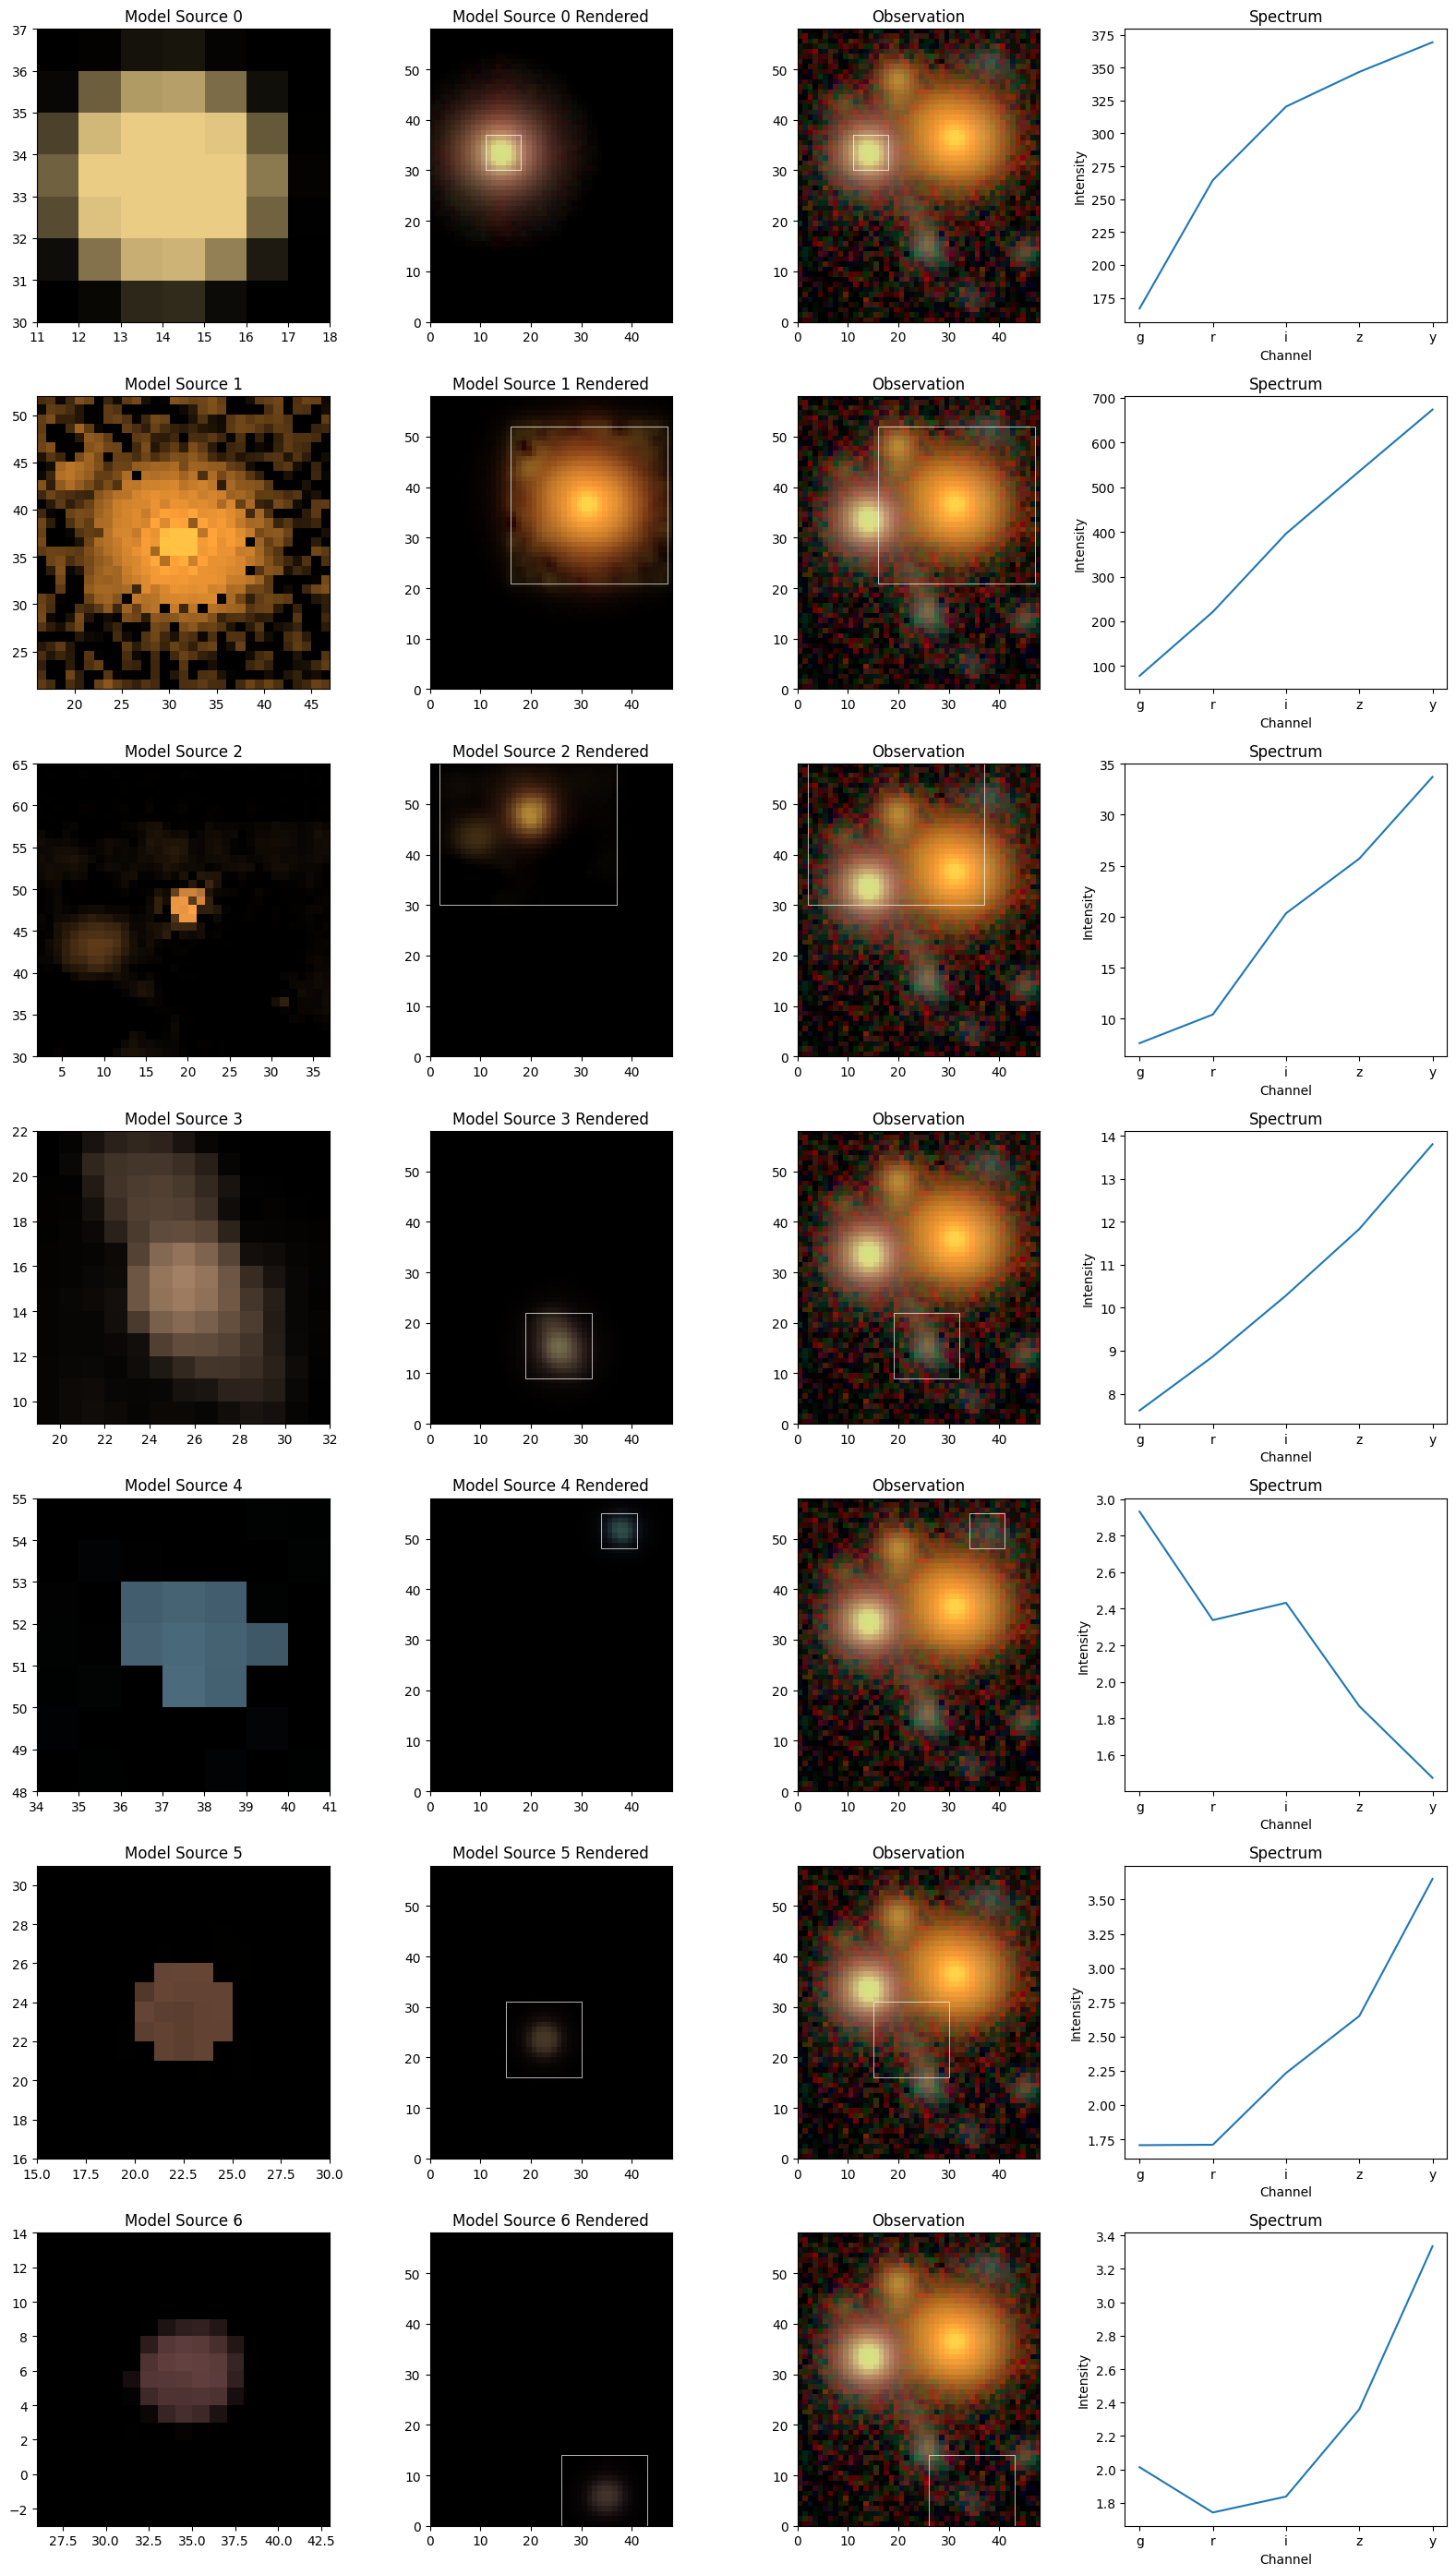

In [14]:
plot.sources(scene_,
             norm=norm,
             observation=obs,
             show_model=True,
             show_rendered=True,
             show_observed=True,
             show_spectrum=True,
             add_markers=False,
             add_boxes=True,
)
plt.show()

The results for most of the galaxies look very reasonable now, in particular for the fainter ones. They remain compact and not affected by noise. Source #1 and #2 use the larger prior (64x64 pixels), which is not quite as robust as the one for 32x32 pixel images, so we see artifacts from pixel noise and neighboring objects. This prior has not been trained (yet) on as many galaxies and is therefore still somewhat weak. An update will fix this soon.